In [1]:
from fastai2.vision.all import *
from faststyle import *

In [2]:
source = Path('/notebooks/storage/data/coco_sample')

In [3]:
source_train = untar_data('http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip',
                          dest='/storage/data/DIV2K')
source_val   = untar_data('http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 
                          dest='/storage/data/DIV2K')
source_DIV2K = source_train.parent

In [4]:
style_fn = 'styles/village.jpg'

In [5]:
dblock = DataBlock(style_blocks, get_items=get_image_files, splitter=RandomSplitter(.1),
                   item_tfms=[Resize(192)],
                   batch_tfms=[*aug_transforms(2, size=128),
                               NormalizeX.from_stats(*coco_stats)])

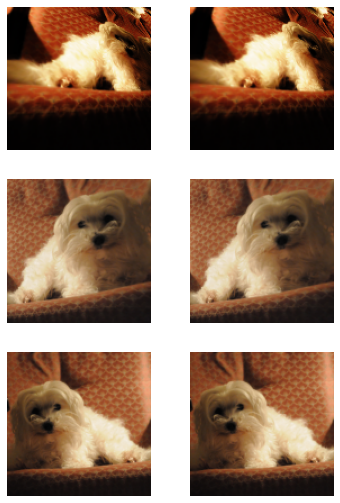

In [6]:
dls = dblock.dataloaders(source, bs=64)
dls.show_batch(max_n=3, nrows=3, unique=True)

In [7]:
arch = resnet18
body = create_body(arch, pretrained=False)
model_splitter = model_meta[arch]['split']

In [8]:
m = DynamicUnet(body, 3, (128,128), blur=True, self_attention=True,
                y_range=(0,1), norm_type=NormType.Instance)

In [9]:
layer_feats = LayerFeats.from_feat_m(FeatModels.vgg19)

In [10]:
loss_func = FastStyleLoss(stl_w=1e5, tv_w=300)
learn = style_learner(dls, m, layer_feats, style_fn, splitter=model_splitter, loss_func=loss_func)

In [11]:
learn.load('unet-stage2')

SuggestedLRs(lr_min=0.33113112449646, lr_steep=5.248074739938602e-05)

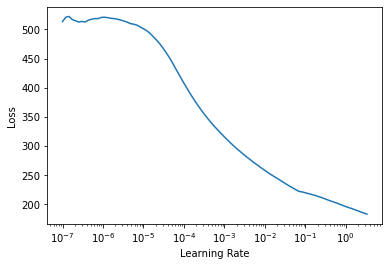

In [11]:
learn.lr_find()

In [12]:
learn.fit_one_cycle(1, 1e-1, pct_start=.9)

epoch,train_loss,valid_loss,stl,cnt,tv,time
0,40.608757,37.186756,18.345369,13.485089,5.356303,04:50


In [19]:
learn.fit_one_cycle(10, 1e-3, pct_start=.2)

epoch,train_loss,valid_loss,stl,cnt,tv,time
0,27.194977,28.768373,11.620547,12.554001,4.593830,04:48
1,27.144011,28.654636,11.452895,12.539652,4.662089,04:48
2,26.984722,28.488579,11.407301,12.527524,4.553754,04:49
3,26.876219,28.383249,11.328615,12.482594,4.572040,04:49
4,26.698111,28.280544,11.312943,12.419824,4.547780,04:49
5,26.639860,28.171732,11.200660,12.444615,4.526452,04:49
6,26.581446,28.125904,11.159981,12.430879,4.535044,04:49
7,26.546648,28.076595,11.134805,12.413085,4.528700,04:49
8,26.566475,28.047077,11.113245,12.402388,4.531442,04:49
9,26.560946,28.042458,11.107694,12.398828,4.535937,04:49


In [20]:
learn.save('unet-raw')

In [12]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, 1e-3), pct_start=.22)

epoch,train_loss,valid_loss,stl,cnt,tv,time
0,30.391558,32.624428,4.388433,23.944952,4.291037,05:01
1,30.052052,32.175106,4.361221,23.768803,4.045082,04:52
2,29.075827,31.364876,4.199712,23.404076,3.761096,04:52
3,28.889482,31.204979,4.187682,23.302916,3.714383,04:52
4,28.738647,31.161102,4.190118,23.268772,3.702209,04:49


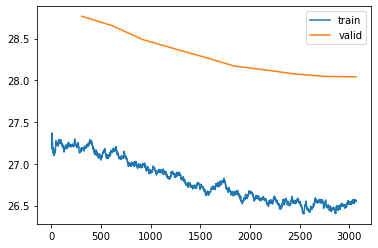

In [21]:
learn.recorder.plot_loss()

In [22]:
learn.save('unet-raw2')

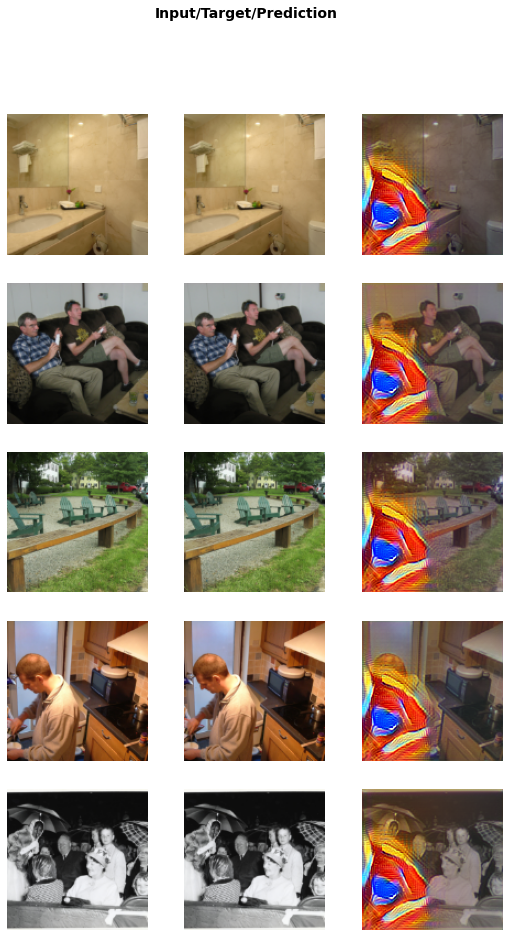

In [23]:
learn.show_results()